# Mall Customer Segmetation


## Import Libraries


In [ ]:
# Import the libraries
import numpy as np
import pandas as pd

import kagglehub
from kagglehub import KaggleDatasetAdapter

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

import os
import pickle

## Load Dataset


In [2]:
# Set the path to the csv file
file_path = "train.csv"

# Load the dataset into pandas dataframe
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "debarghamitraroy/mall-customers-segmentation-dataset",
    file_path,
)

df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# Dimensions of the dataset (rows, columns)
print("Dimensions of the dataset:", df.shape)

Dimensions of the dataset: (200, 5)


In [4]:
# Description of the Dataset
print("Data description:")
df.describe()

Data description:


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## Exploratory Data Analysis


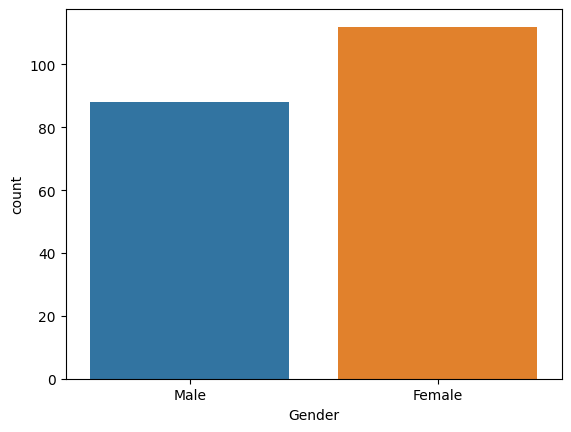

In [5]:
# Plot the frequency of each gender in the dataset
sns.countplot(df, x="Gender", hue="Gender")  # Count plot
plt.show()

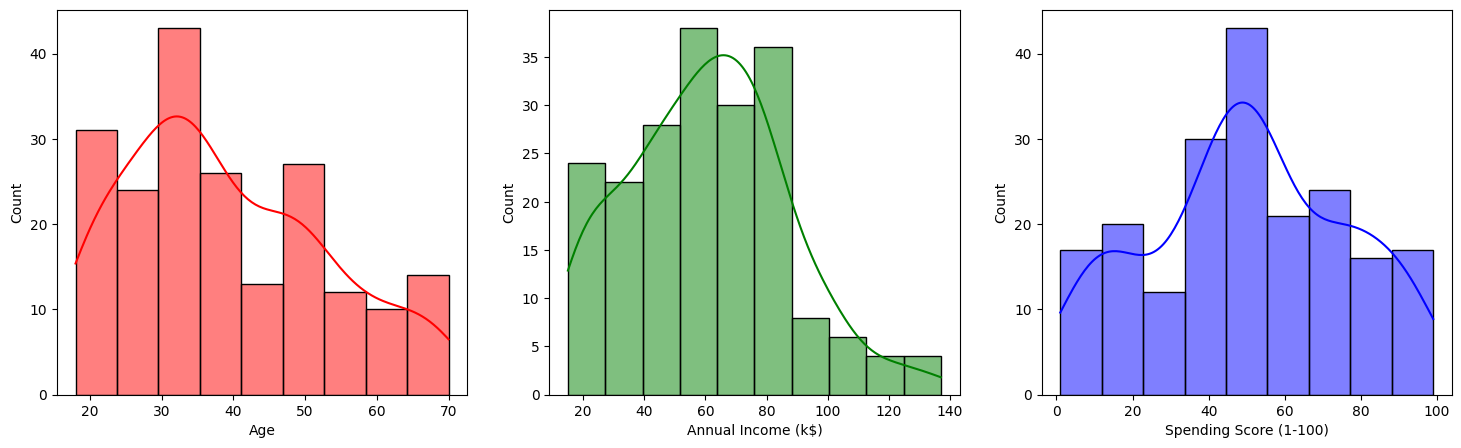

In [6]:
# Plot histograms with KDE for Age, Annual Income (k$), and Spending Score (1–100)
cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]  # Features
colors = ["red", "green", "blue"]  # Colors

# Create a (1, 3) subplot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))  # Subplot

for ax, col, c in zip(axes, cols, colors):
    sns.histplot(df[col], kde=True, ax=ax, color=c)  # Histogram with KDE

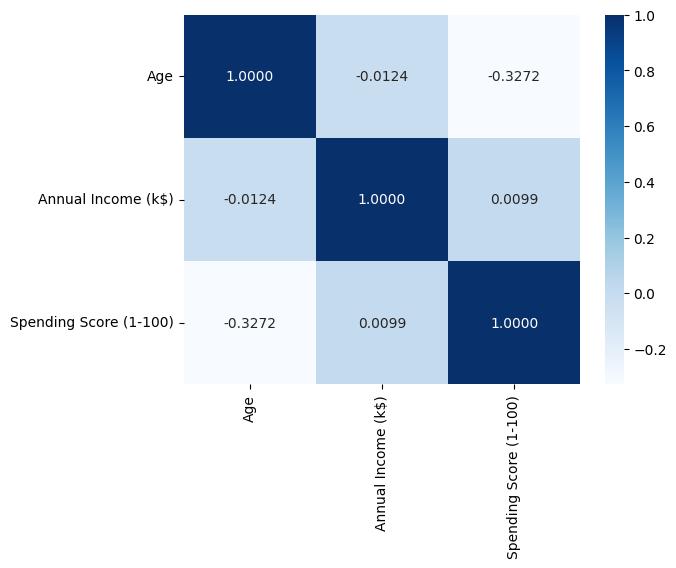

In [7]:
# Finding the correlation between Age, Annual Income (k$), and Spending Score (1–100)
corr = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].corr()

# Plot the correlation using a heatmap
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".4f")
plt.show()

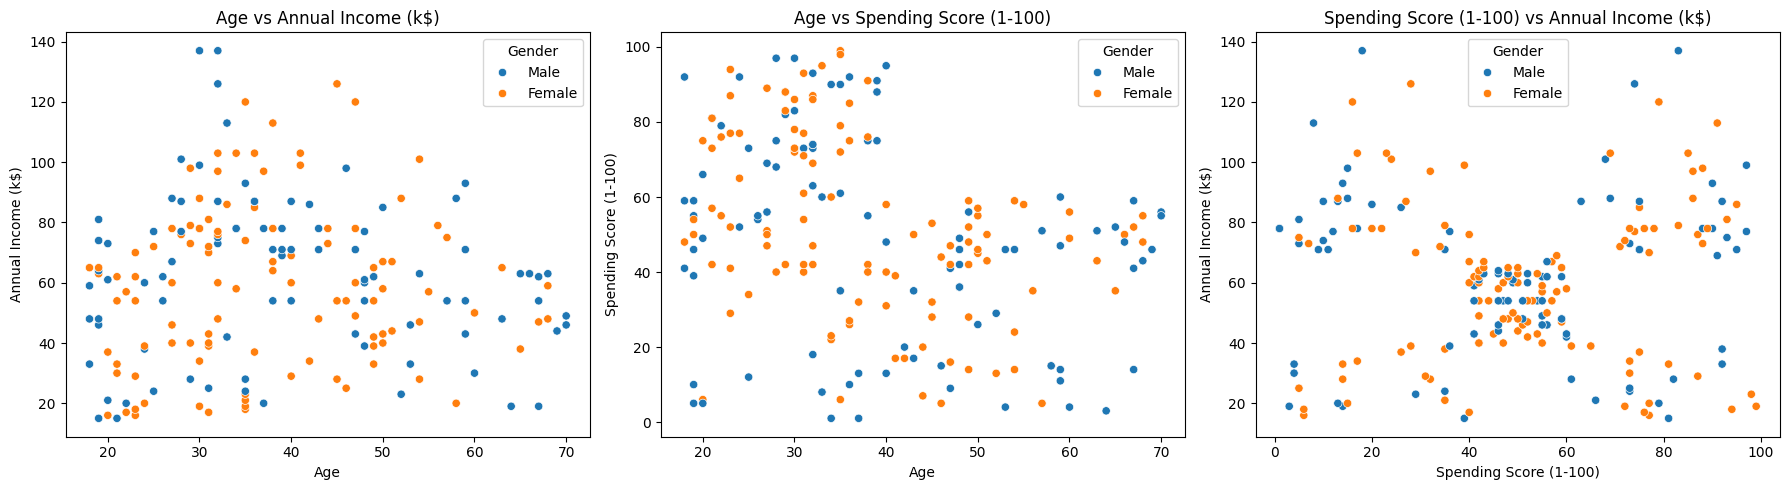

In [8]:
# Create a (1, 3) subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Age vs Annual Income (k$)
sns.scatterplot(data=df, x="Age", y="Annual Income (k$)", hue="Gender", ax=axes[0])
axes[0].set_title("Age vs Annual Income (k$)")

# Plot 2: Age vs Spending Score (1-100)
sns.scatterplot(data=df, x="Age", y="Spending Score (1-100)", hue="Gender", ax=axes[1])
axes[1].set_title("Age vs Spending Score (1-100)")

# Plot 3: Spending Score (1-100) vs Annual Income (k$)
sns.scatterplot(
    data=df,
    x="Spending Score (1-100)",
    y="Annual Income (k$)",
    hue="Gender",
    ax=axes[2],
)
axes[2].set_title("Spending Score (1-100) vs Annual Income (k$)")

plt.tight_layout()
plt.show()

## K-Means Clustering


### Selecting the features


In [9]:
# Select the important features: "Annual Income (k$)", and "Spending Score (1–100)"
X = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]

### Performing Elbow method to find out the optimal number of cluster


In [10]:
# Compute the WCSS to determine the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

### Plot the Elbow Method


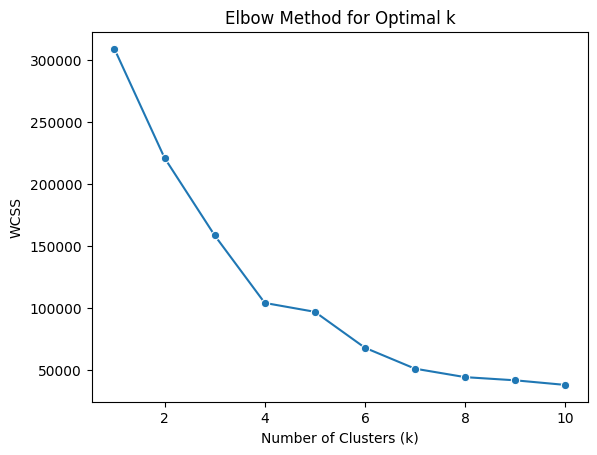

In [11]:
sns.lineplot(x=range(1, 11), y=wcss, marker="o")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal k")
plt.show()

### Perform K-Means Clustering


In [12]:
# Perform K-Means clustering for k = 4
kmeans = KMeans(n_clusters=4, random_state=42)
y_pred = kmeans.fit_predict(X)

### Plot the 3D Clustering


In [13]:
# Create DataFrame for plotting
plot_df_kmeans = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].copy()

# Convert cluster labels to pandas Series before string concat
plot_df_kmeans["Cluster"] = "Cluster-" + pd.Series(
    y_pred, index=plot_df_kmeans.index
).astype(str)

# Create 3D scatter plot
fig = px.scatter_3d(
    plot_df_kmeans,
    x="Age",
    y="Annual Income (k$)",
    z="Spending Score (1-100)",
    color="Cluster",
    title="Customer Segmentation using K-Means",
    opacity=0.8,
)

# Add centroids
centroids_array = np.asarray(kmeans.cluster_centers_)
centroids = pd.DataFrame(
    data=centroids_array,
    columns=["Age", "Annual Income (k$)", "Spending Score (1-100)"],
)

fig.add_scatter3d(
    x=centroids["Age"],
    y=centroids["Annual Income (k$)"],
    z=centroids["Spending Score (1-100)"],
    mode="markers",
    marker=dict(size=8, symbol="x"),
    name="Centroids",
)

fig.show()

## DBSCAN Clustering


### Scale the Features


In [14]:
# Create scaler
scaler = StandardScaler()

# Fit and transform
X_scaled = scaler.fit_transform(X)

### Finding the optimal value of `eps`


#### Find optimal `eps` using the k-distance graph


In [15]:
k = 5  # min_samples

# compute k-nearest neighbor distances for eps estimation
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances
distances = np.sort(distances[:, k - 1])

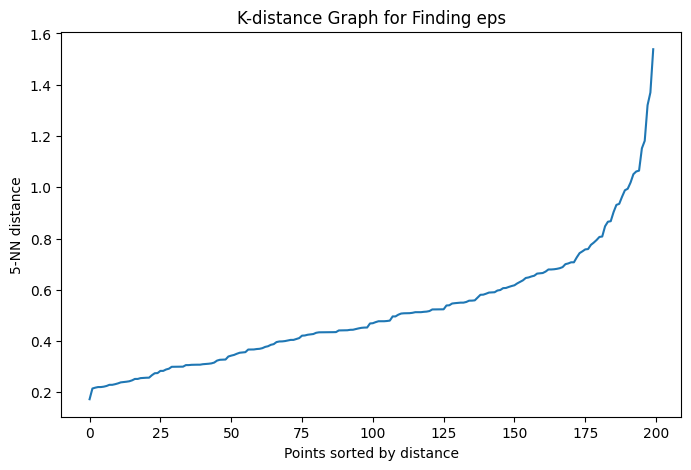

In [16]:
# Plot k-distance graph
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-NN distance")
plt.title("K-distance Graph for Finding eps")
plt.show()

#### Choose `eps`


From the K-distance graph you shared, the optimal value of `eps` is approximately $0.6$.

- The curve increases slowly and smoothly up to about $0.55-0.6$
- After $\approx 0.6$, it starts rising very sharply
- That sharp upward turn is the elbow, which DBSCAN uses as the cutoff between dense points and noise


### Finding the optimal value of `min_samples`


#### Try multiple `min_samples` values


In [17]:
silhouette_score_list = []  # Empty list to store the silhouette scores

for min_samples in list(range(1, 201)):
    db = DBSCAN(eps=0.6, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)

    # Ignore noise points (-1)
    if len(set(labels)) > 1:
        score = silhouette_score(X_scaled, labels)
        silhouette_score_list.append((min_samples, score))
        print(
            f"min_samples: {min_samples}, clusters: {len(set(labels))- (1 if -1 in labels else 0)}, silhouette score: {score:.4f}"
        )

min_samples: 1, clusters: 13, silhouette score: -0.1860
min_samples: 2, clusters: 7, silhouette score: -0.0025
min_samples: 3, clusters: 3, silhouette score: 0.1779
min_samples: 4, clusters: 3, silhouette score: 0.1553
min_samples: 5, clusters: 2, silhouette score: 0.1880
min_samples: 6, clusters: 5, silhouette score: 0.0762
min_samples: 7, clusters: 4, silhouette score: 0.2568
min_samples: 8, clusters: 4, silhouette score: 0.2526
min_samples: 9, clusters: 4, silhouette score: 0.2858
min_samples: 10, clusters: 4, silhouette score: 0.2904
min_samples: 11, clusters: 4, silhouette score: 0.2792
min_samples: 12, clusters: 4, silhouette score: 0.2473
min_samples: 13, clusters: 5, silhouette score: 0.1779
min_samples: 14, clusters: 5, silhouette score: 0.1757
min_samples: 15, clusters: 3, silhouette score: 0.0862
min_samples: 16, clusters: 3, silhouette score: 0.0550
min_samples: 17, clusters: 3, silhouette score: -0.0161
min_samples: 18, clusters: 3, silhouette score: -0.0203
min_samples: 1

#### Get the best `min_samples`


In [18]:
best_min_samples, best_score = max(
    silhouette_score_list, key=lambda x: x[1]  # compare by silhouette score
)

print(f"Optimal min_samples: {best_min_samples}")
print(f"Best silhouette score: {best_score:.4f}")

Optimal min_samples: 10
Best silhouette score: 0.2904


#### Store results in a DataFrame


In [19]:
df_min_sample = pd.DataFrame(
    silhouette_score_list, columns=["min_samples", "silhouette_score"]
)

# Best value
df_min_sample.sort_values("silhouette_score", ascending=False).head(1)

,min_samples,silhouette_score
9,10,0.290436


#### Plot to visually verify


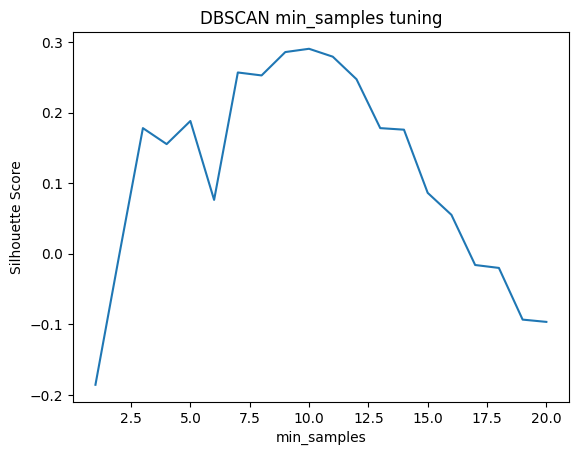

In [20]:
plt.plot(df_min_sample["min_samples"], df_min_sample["silhouette_score"])
plt.xlabel("min_samples")
plt.ylabel("Silhouette Score")
plt.title("DBSCAN min_samples tuning")
plt.show()

#### Choose `min_samples`


- The highest silhouette score ($0.2904$) occurs at `min_samples = 10`
- After that, the score steadily drops $\rightarrow$ clusters become less distinct
- Very large min_samples collapse the data into too few clusters and even give negative scores

So, the optimal `min_samples = 10`


### Perform DBSCAN Clustering


In [21]:
# Apply DBSCAN clustering on the scaled feature set
dbscan = DBSCAN(eps=0.6, min_samples=best_min_samples)
labels = dbscan.fit_predict(X_scaled)

### Plot the 3-D Cluster


In [22]:
# Create DataFrame for plotting
plot_df_dbscan = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].copy()
plot_df_dbscan["Cluster"] = "Cluster-" + pd.Series(
    labels, index=plot_df_dbscan.index
).astype(str)

# Mark noise points (-1) clearly
plot_df_dbscan["Cluster"] = plot_df_dbscan["Cluster"].replace("Cluster--1", "Noise")

# Create interactive 3D scatter plot
fig = px.scatter_3d(
    plot_df_dbscan,
    x="Age",
    y="Annual Income (k$)",
    z="Spending Score (1-100)",
    color="Cluster",
    title="Customer Segmentation using DBSCAN",
    opacity=0.8,
)

fig.show()

## Store the trained clustering model


In [23]:
# Create model directory if it doesn't exist
os.makedirs("model", exist_ok=True)

In [24]:
# Export the trained model
pickle.dump(kmeans, open("./model/kmeans.pkl", "wb"))
pickle.dump(dbscan, open("./model/dbscan.pkl", "wb"))